# Executive Summary

### Model Comparison: Logistic Regression vs. XGBoost

In the development of two modeling approaches, I have found the strengths and weaknesses of each algorithm as seen in __Table 1__ below:

|__Table 1: Model Comparison__|
|:-:|

||Logistic Regression|XGBoost|
|:-|:-:|:-:|
|Interpretability|Interpretable relationship between target and predictors|Lack of interpretability beyond variable importance|
|Accuracy|Relatively less accurate|Relatively more accurate|
|Speed|Computationally faster|Computationally slower|
|Tunning|Less sensitive to tuning parameters|More sensitive to tuning parameters|


### Model Evaluation

After building a final model of each algorithm, I compared their estimates for the test Area under the ROC curve (AUROC) on the training data set. According to the final AUROC value from each model, I think the XGBoost model will perform better.

|__Table 2: Model Evaluation__|
|:-:|

||Logistic Regression|XGBoost|
|:-|-:|:-:|
|AUROC|0.7723|0.8405|


### Model Recommendation
Since two algorithms have their strengths and weakness, I would recommend a model that could satisfy a business partner's needs and business problems that they want to resolve. For example, if the business partner wants to know the relationship between the target and the predictors and wants a fast solution, I recommend a logistic regression model. However, the business partner wants accurate predictions for their target and relatively allows for the flexibility for restrictions about model building, then I would recommend an XGBoost model.

# Data Processing

In [1]:
# load packages
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.stats import uniform
import csv
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set print options
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
# Read in data sets
train = pd.read_csv("C:\\Users\\james\\OneDrive\\Desktop\\Coding\\Jupyter Notebook\\State Farm\\exercise_40_train.csv")
test = pd.read_csv("C:\\Users\\james\\OneDrive\\Desktop\\Coding\\Jupyter Notebook\\State Farm\\exercise_40_test.csv")

# Print first 5 rows
display(train.head())
display(test.head())

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,1.171788,109.626841,4.644568,4.814885,1.541740,-0.587361,101.906052,4.278444,77.709700,$-908.650758424405,7.328029,36.601967,126.384294,1.264713,female,3.834082,2.352406,905.491445,14.779467,0.752524,NaN,no,-0.597288,Colorado,46.667221,3.159002,69.444841,32.450076,NaN,5-10 miles,18.129499,NaN,0.904626,1.227266,0.703326,-0.810371,0.234654,53.359113,58.251700,16.084987,1602.756464,2.740134,7.617666,72.167186,0.166127,NaN,-1.532562,NaN,300.629990,0,August,9.840873,6.600008,1.252479,46.992716,farmers,1.212048,12.896733,15.263491,0.518653,0.543768,-0.912506,53.521544,7.723719,NaN,NaN,NaN,mercedes,51.287604,1.0,11.131462,-0.471594,-3.261865,0.085710,0.383351,126.935322,47.872599,-0.162668,1.079562,10.602395,2.770844,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,1.419900,84.079367,1.459868,1.443983,NaN,-1.165869,100.112121,8.487132,70.808566,$-1864.9622875143,6.796408,3.789176,93.037021,0.346201,male,4.345028,1.651579,868.784447,25.914680,1.445294,NaN,no,1.127376,Tennessee,47.928569,-1.013712,61.289132,35.521824,31.526217,5-10 miles,11.389081,99074.100620,-1.157897,-0.822055,-0.851141,2.651773,1.104631,37.728834,56.052749,NaN,3350.837875,1.995635,NaN,73.964560,NaN,NaN,0.956001,NaN,300.629990,0,April,6.939395,3.864254,0.057936,48.216622,allstate,0.738526,14.402071,33.940951,-0.140384,1.016703,-0.000234,46.797571,7.260365,-1.731529,0.666354,-2.870800,mercedes,42.918352,NaN,11.715043,1.691428,-4.789183,4.684722,2.138771,102.409522,46.584780,1.252022,1.223852,10.408146,3.703013,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,-1.247022,95.375221,1.098525,1.216059,0.450624,0.211685,99.215210,8.601193,75.922820,$-543.187402955527,3.802395,7.407996,71.022413,0.070968,male,4.332644,-0.375737,1077.233497,13.177479,4.174536,NaN,no,2.605279,Texas,56.674425,0.108486,69.798923,30.684074,31.049447,5-10 miles,14.372443,100087.339539,0.869508,0.150728,NaN,-0.856591,-2.561083,50.236892,63.975108,6.998154,3756.910196,1.772648,15.057485,59.428690,1.844493,NaN,4.127857,NaN,182.369349,0,September,6.228138,1.370661,-0.239705,54.120933,geico,-0.032980,14.402071,18.211817,-0.819798,1.010811,-0.000234,48.202036,9.336021,0.209817,1.124866,-3.558718,subaru,55.020333,1.0,5.660882,-2.608974,-6.387984,2.506272,2.138771,NaN,53.977291,0.657292,-0.353469,NaN,3.997183,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,2.223038,96.420382,-1.390239,3.962961,NaN,-2.046856,NaN,6.611554,74.966925,$-182.626380634258,7.728963,8.136213,121.610846,0.700954,male,7.294990,-0.603983,1051.655489,17.006528,2.347355,NaN,no,1.071202,Minnesota,59.154933,1.319711,65.408246,34.401290,48.363690,5-10 miles,13.191173,100934.096543,NaN,-0.965711,NaN,0.422522,-2.123048,41.857197,59.226119,NaN,1961.609788,3.155214,NaN,68.671023,-1.020225,5.833712,0.663759,NaN,300.629990,0,September,6.005140,0.013162,0.318335,54.784192,geico,-0.466535,14.402071,14.629914,1.389325,0.704880,-1.510949,49.882647,5.661421,1.606797,1.726010,-0.398417,nissan,47.769343,1.0,7.472328,1.424316,-5.431998,3.285291,2.138771,105.208424,49.543472,2.066346,1.761266,NaN,2.933707,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,-0.275406,90.76

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,4.747627,20.509439,Wednesday,2.299105,-1.815777,-0.752166,0.0098%,-3.240309,0.587948,-0.260721,101.113628,-0.812035,3.251085,-0.004432,-0.917763,102.193597,7.097387,75.256714,$120.216189955777,8.269754,4.794438,56.134458,-0.083641,NaN,5.740955,-3.152540,924.013304,17.697125,1.402273,NaN,no,1.461654,Florida,57.930285,4.727300,66.416594,28.450466,33.499310,5-10 miles,16.776061,99971.844703,0.492812,-0.963616,NaN,NaN,1.266416,53.020326,61.840284,NaN,1825.413159,2.517924,NaN,70.880778,NaN,1.923125,0.239009,NaN,300.62999,0,May,5.461123,5.149473,1.179229,59.346822,progressive,2.219502,17.667792,5.557066,-2.030901,0.636111,-0.000234,62.363381,4.613878,2.415655,3.632041,-0.382482,mercedes,55.938387,1.0,8.325299,-1.274085,-5.663245,2.402660,-0.061040,NaN,64.002500,0.548974,3.420875,11.553023,5.904644,NaN,12.542333,no,3.107683,0.533904,12.438759,7.298306,0,NaN,93.567120
1,1.148654,19.301465,Fri,1.862200,-0.773707,-1.461276,0.0076%,0.443209,0.522113,-1.090886,104.791999,8.805876,1.651993,NaN,-1.396065,99.356609,7.117930,79.061540,$-267.562586413086,5.668347,12.377178,NaN,0.321981,female,2.058123,-0.442525,1107.628399,15.747234,2.027073,NaN,yes,0.608259,North Carolina,55.646392,0.789132,68.881807,32.242558,-1.034680,5-10 miles,11.959804,99910.554923,0.547935,1.001799,1.315020,3.229084,5.873890,49.116516,61.279131,9.360134,1818.390072,2.269700,0.336755,69.832156,2.666487,1.224195,-1.214940,NaN,300.62999,0,July,6.520113,2.101449,-0.871509,NaN,allstate,1.289800,14.402071,7.302161,-1.553879,1.352019,-0.000234,54.104054,9.010198,0.537178,1.489493,-1.106853,ford,44.322947,1.0,6.088895,1.878944,-8.237793,3.636347,3.726452,105.488589,53.387201,-0.751229,0.295234,6.212811,4.876645,-0.848567,7.213829,yes,4.276078,NaN,10.386987,12.527094,1,yes,98.607486
2,4.986860,18.769675,Saturday,1.040845,-1.548690,2.632948,-5e-04%,-1.167885,5.739275,0.222975,102.109546,7.831517,3.055358,2.036434,1.057296,NaN,10.943217,87.567827,$-311.292903116571,3.219583,31.135956,50.048638,1.174485,male,1.609278,-0.303259,1009.911508,12.008190,0.618778,NaN,no,0.680923,NaN,53.178113,0.869321,70.249633,35.207243,48.980294,5-10 miles,14.564732,100729.380783,0.096947,-0.490053,NaN,1.333292,0.750075,48.258898,63.737244,11.564194,1815.680559,1.704048,NaN,67.090400,1.547230,NaN,1.428580,NaN,300.62999,0,January,12.190433,1.793349,-0.114922,48.121885,progressive,-1.755707,14.402071,9.903803,1.720469,0.765756,-0.000234,51.522621,11.700359,-1.867170,0.383319,-1.078648,NaN,48.854080,1.0,8.711055,-0.073306,-8.739095,NaN,2.138771,NaN,49.687134,2.641871,1.718243,NaN,4.455432,1.143388,10.483928,no,2.090868,-1.780474,11.328177,11.628247,0,yes,94.578246
3,3.709183,18.374375,Tuesday,-0.169882,-2.396549,-0.784673,-0.016%,-2.662226,1.548050,0.210141,82.653354,0.436885,1.578106,NaN,-1.287913,102.410965,6.588790,71.825782,$2229.14940030076,7.459929,1.822459,88.144007,0.909556,female,8.864059,0.641209,841.889126,20.904196,0.725017,NaN,no,0.622849,Mississippi,50.311869,0.453211,65.253390,34.432292,52.756665,5-10 miles,18.503815,101476.778846,0.888038,-0.007376,-1.126059,1.129508,-0.455920,44.525657,60.008453,12.852088,2251.680231,2.915405,5.895661,75.219207,NaN,NaN,-0.415800,NaN,300.62999,0,July,6.865209,5.083537,1.685063,46.761738,geico,-0.807993,14.402071,16.576216,0.033036,0.284538,-0.000234,54.625974,13.160347,-0.329204,2.171326,-0.109125,subaru,NaN,1.0,11.742605,-0.253294,-6.641284,4.755348,2.138771,NaN,NaN,1.811825,0.461637,18.198978,3.947223,0.693646,3.862867,no,2.643847,1.662240,10.064961,10.550014,1,NaN,100.346261
4,3.801616,20.205541,Monday,2.092652,-0.732784,-0.703101,0.0186%,0.056422,2.878167,-0.457618

In [4]:
# Print dimension of each data set
display(train.shape)
display(test.shape)

(40000, 101)

(10000, 100)

In [5]:
# Check distribution of target variable y in training set
train.y.value_counts(normalize = True).mul(100).round(2)

0    85.49
1    14.51
Name: y, dtype: float64

No quasi-complete separation issues detected. No need for oversampling the target variable.

## Missing Value Treatment

In [6]:
# Check missing values: train
null = train.isnull().sum().to_frame(name = 'nulls').T
dtype = train.dtypes.to_frame(name = 'dtypes').T
nunique = train.nunique().to_frame(name = 'unique').T
train_miss_df = pd.concat([null, dtype, nunique], axis = 0)

# Print data frame
display(train_miss_df)

# Check missing values: test
null = test.isnull().sum().to_frame(name = 'nulls').T
dtype = test.dtypes.to_frame(name = 'dtypes').T
nunique = test.nunique().to_frame(name = 'unique').T
test_miss_df = pd.concat([null, dtype, nunique], axis = 0)

# Print data frame
display(test_miss_df)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
nulls,0,0,0,0,0,2428,0,0,0,0,0,5110,0,0,9864,0,11212,0,0,0,0,0,2387,0,3856,0,2433,0,0,0,32336,0,0,7171,0,0,0,0,2402,0,0,9503,9729,0,34247,8009,0,0,0,12823,0,0,16182,0,12728,17696,0,32464,0,0,0,7293,0,2420,5101,0,0,2425,2384,0,0,0,0,0,12916,5245,5249,9257,11373,2430,5256,0,0,2428,0,9715,2407,0,2331,10691,0,5259,2435,0,2340,12604,6638,0,0,12836,0
dtypes,int64,float64,float64,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,float64,object,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,int64,object,float64
unique,2,39884,39849,14,39849,37414,39854,663,39842,39871,39776,34879,39933,39913,29944,39837,28630,39902,39970,40000,39935,40000,37602,39767,2,39907,37423,39996,39943,39813,7660,2,39838,51,39962,39832,39944,39936,37585,1,39903,30497,30161,39761,5749,31872,39882,39943,39962,27146,39999,39850,23802,39955,27213,22265,39861,7536,4250,2,12,32660,39896,37463,34865,5,39843,2921,37585,39838,38053,3068,39958,39966,27028,34650,34605,7,28600,2,34679,39845,39881,37483,3868,30273,37548,39828,37499,29266,39811,34623,37507,2,37512,27337,33261,39884,2,1,39958


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
nulls,0,0,0,0,602,0,0,0,0,0,1329,0,0,2428,0,2753,0,0,0,0,0,613,0,969,0,617,0,0,0,8085,0,0,1770,0,0,0,0,565,0,0,2404,2418,0,8566,2063,0,0,0,3254,0,0,4080,0,3206,4424,0,8077,0,0,0,1766,0,587,1262,0,0,620,600,0,0,0,0,0,3163,1266,1356,2318,2866,610,1315,0,0,572,0,2419,602,0,591,2675,0,1310,626,0,615,3172,1628,0,0,3300,0
dtypes,float64,float64,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,float64,object,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,int64,object,float64
unique,9993,9993,14,9990,9391,9992,570,9995,9994,9989,8670,9995,9990,7559,9988,7235,9993,10000,10000,9998,10000,9387,9987,2,9992,9378,10000,9997,9992,1915,2,9989,51,9995,9985,9996,9995,9433,1,9995,7596,7575,9984,1434,7930,9994,9997,9999,6743,10000,9989,5918,9998,6789,5576,9990,1923,1057,2,12,8230,9995,9402,8734,5,9990,736,9397,9991,9863,745,9998,9995,6834,8724,8635,7,7133,2,8681,9992,9991,9424,944,7581,9395,9989,9398,7322,9991,8677,9371,2,9374,6826,8367,9989,2,1,9992


In both data sets, the columns of x30, x44, x57 have more than 50% of missing values.

### Training set: categorical variables

In [7]:
# Create a boolean mask for categorical columns
cate_mask = (train.dtypes == object)

# Get a list of categorical column names
cate_cols = train.columns[cate_mask].tolist()

# Print first 5 rows
train_cate = train[cate_cols]
display(train_cate.head())

# Identify categorical columns with missing values
display(train_cate.columns[train_cate.isnull().any()])

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Wed,0.0062%,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Friday,0.0064%,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thursday,-8e-04%,$-543.187402955527,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tuesday,-0.0057%,$-182.626380634258,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sunday,0.0109%,$967.007090837503,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes


Index(['x24', 'x33', 'x77', 'x99'], dtype='object')

In [8]:
# Print distribution of values in each categorical column
for i in range(len(cate_cols)):
    print(cate_cols[i])
    print(train[cate_cols[i]].value_counts(normalize = True).mul(100).round(2))
    print()

x3
Wednesday    12.32
Monday       10.36
Friday        9.94
Tuesday       9.79
Sunday        9.02
Saturday      8.99
Tue           7.37
Thursday      6.98
Mon           5.50
Wed           5.11
Sat           4.47
Thur          4.11
Fri           4.05
Sun           2.00
Name: x3, dtype: float64

x7
0.0022%     0.48
0.0011%     0.47
-0.0016%    0.46
6e-04%      0.46
0.0019%     0.45
            ... 
0.0312%     0.00
0.0288%     0.00
0.0344%     0.00
0.029%      0.00
-0.0408%    0.00
Name: x7, Length: 663, dtype: float64

x19
$-1701.4432299895     0.0
$-620.742227366701    0.0
$462.219926258605     0.0
$1497.44859767623     0.0
$95.5861821213935     0.0
                     ... 
$-346.866154333237    0.0
$474.143546384627     0.0
$-538.584172882992    0.0
$-303.925842369489    0.0
$-2771.33407834604    0.0
Name: x19, Length: 40000, dtype: float64

x24
female    50.24
male      49.76
Name: x24, dtype: float64

x31
no     85.06
yes    14.94
Name: x31, dtype: float64

x33
California        10

In [9]:
# Impute missing values in categorical columns with a category of Missing
train[['x24', 'x33', 'x77', 'x99']] = train[['x24', 'x33', 'x77', 'x99']].fillna('Missing')

Why did I impute with a 'Missing' category?

I imputed the missing values in the categorical variables with a category of 'Missing'. Because Missing can be another category itself and we might find a certain pattern of missingness.

### Training set: numeric variables

In [10]:
# Count dtypes in training set
train.dtypes.value_counts()

float64    86
object     12
int64       3
dtype: int64

In [11]:
# Create a boolean mask for numeric columns
num_mask = (train.dtypes != object)

# Get a list of categorical column names
num_cols = train.columns[num_mask].tolist()

# Print first 5 rows
train[num_cols].head()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x20,x21,x22,x23,x25,x26,x27,x28,x29,x30,x32,x34,x35,x36,x37,x38,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x61,x62,x63,x64,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
0,0,0.165254,18.060003,1.077380,-1.339233,-1.584341,0.220784,1.816481,1.171788,109.626841,4.644568,4.814885,1.541740,-0.587361,101.906052,4.278444,77.709700,7.328029,36.601967,126.384294,1.264713,3.834082,2.352406,905.491445,14.779467,0.752524,NaN,-0.597288,46.667221,3.159002,69.444841,32.450076,NaN,18.129499,NaN,0.904626,1.227266,0.703326,-0.810371,0.234654,53.359113,58.251700,16.084987,1602.756464,2.740134,7.617666,72.167186,0.166127,NaN,-1.532562,NaN,300.629990,0,9.840873,6.600008,1.252479,46.992716,1.212048,12.896733,15.263491,0.518653,0.543768,-0.912506,53.521544,7.723719,NaN,NaN,NaN,51.287604,1.0,11.131462,-0.471594,-3.261865,0.085710,0.383351,126.935322,47.872599,-0.162668,1.079562,10.602395,2.770844,-0.397427,0.909479,5.492487,NaN,10.255579,7.627730,0,104.251338
1,1,2.441471,18.416307,1.482586,0.920817,-0.759931,1.192441,3.513950,1.419900,84.079367,1.459868,1.443983,NaN,-1.165869,100.112121,8.487132,70.808566,6.796408,3.789176,93.037021,0.346201,4.345028,1.651579,868.784447,25.914680,1.445294,NaN,1.127376,47.928569,-1.013712,61.289132,35.521824,31.526217,11.389081,99074.100620,-1.157897,-0.822055,-0.851141,2.651773,1.104631,37.728834,56.052749,NaN,3350.837875,1.995635,NaN,73.964560,NaN,NaN,0.956001,NaN,300.629990,0,6.939395,3.864254,0.057936,48.216622,0.738526,14.402071,33.940951,-0.140384,1.016703,-0.000234,46.797571,7.260365,-1.731529,0.666354,-2.870800,42.918352,NaN,11.715043,1.691428,-4.789183,4.684722,2.138771,102.409522,46.584780,1.252022,1.223852,10.408146,3.703013,0.656651,9.093466,3.346429,4.321172,NaN,10.505284,1,101.230645
2,1,4.427278,19.188092,0.145652,0.366093,0.709962,0.952323,0.782974,-1.247022,95.375221,1.098525,1.216059,0.450624,0.211685,99.215210,8.601193,75.922820,3.802395,7.407996,71.022413,0.070968,4.332644,-0.375737,1077.233497,13.177479,4.174536,NaN,2.605279,56.674425,0.108486,69.798923,30.684074,31.049447,14.372443,100087.339539,0.869508,0.150728,NaN,-0.856591,-2.561083,50.236892,63.975108,6.998154,3756.910196,1.772648,15.057485,59.428690,1.844493,NaN,4.127857,NaN,182.369349,0,6.228138,1.370661,-0.239705,54.120933,-0.032980,14.402071,18.211817,-0.819798,1.010811,-0.000234,48.202036,9.336021,0.209817,1.124866,-3.558718,55.020333,1.0,5.660882,-2.608974,-6.387984,2.506272,2.138771,NaN,53.977291,0.657292,-0.353469,NaN,3.997183,2.059615,0.305170,4.456565,NaN,8.754572,7.810979,0,109.345215
3,0,3.925235,19.901257,1.763602,-0.251926,-0.827461,-0.520756,1.825586,2.223038,96.420382,-1.390239,3.962961,NaN,-2.046856,NaN,6.611554,74.966925,7.728963,8.136213,121.610846,0.700954,7.294990,-0.603983,1051.655489,17.006528,2.347355,NaN,1.071202,59.154933,1.319711,65.408246,34.401290,48.363690,13.191173,100934.096543,NaN,-0.965711,NaN,0.422522,-2.123048,41.857197,59.226119,NaN,1961.609788,3.155214,NaN,68.671023,-1.020225,5.833712,0.663759,NaN,300.629990,0,6.005140,0.013162,0.318335,54.784192,-0.466535,14.402071,14.629914,1.389325,0.704880,-1.510949,49.882647,5.661421,1.606797,1.726010,-0.398417,47.769343,1.0,7.472328,1.424316,-5.431998,3.285291,2.138771,105.208424,49.543472,2.066346,1.761266,NaN,2.933707,0.899392,5.971782,4.100022,1.151085,NaN,9.178325,1,103.021970
4,0,2.868802,22.202473,3.405119,0.083162,1.381504,-0.732739,2.151990,-0.275406,90.769952,7.230125,3.877312,0.392002,-1.201565,100.626558,9.103015,77.977156,2.272765,24.452102,56.492317,-1.102387,6.313827,0.429187,949.904947,16.962710,0.510985,NaN,2.283921,46.445617,0.022747,66.662910,31.135261,31.819899,17.210430,NaN,NaN,1.012093,NaN,-0.348240,3.477451,47.844153,55.921988,NaN,2345.195505,3.253079,14.193721,71.853326,0.926779,4.115990,-2.273628,NaN,149.725023,0,7.654926,1.305936,0.418272,51.486405,-0.195764,14.4

In [12]:
# Print descriptive statistics for each numeric column
train.describe()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x20,x21,x22,x23,x25,x26,x27,x28,x29,x30,x32,x34,x35,x36,x37,x38,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x61,x62,x63,x64,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,40000.000000,40000.000000,40000.000000,40000.000000,37572.000000,40000.000000,40000.000000,40000.000000,40000.000000,34890.000000,40000.000000,40000.000000,30136.000000,40000.000000,28788.000000,40000.000000,40000.000000,40000.000000,40000.000000,37613.000000,40000.000000,40000.000000,37567.000000,40000.000000,40000.000000,40000.000000,7664.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,37598.000000,40000.000000,30497.000000,30271.000000,40000.000000,5753.000000,31991.000000,40000.000000,40000.000000,40000.000000,27177.000000,40000.000000,40000.000000,23818.000000,40000.000000,27272.000000,22304.000000,40000.000000,7536.000000,40000.000000,40000.000000,32707.000000,40000.000000,37580.000000,34899.000000,40000.000000,37575.000000,37616.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,27084.000000,34755.000000,34751.000000,28627.000000,37570.000000,34744.000000,40000.000000,40000.000000,37572.000000,40000.000000,30285.000000,37593.000000,40000.000000,37669.000000,29309.000000,40000.000000,34741.000000,37565.000000,37660.000000,27396.000000,33362.000000,40000.000000,40000.000000,40000.000000
mean,0.145075,2.999958,20.004865,0.002950,0.005396,0.007234,0.004371,2.722334,0.490339,100.008988,3.039317,3.881807,0.787999,0.011162,100.702408,8.005758,79.936742,4.962774,11.030799,72.135445,0.202855,4.979892,0.001688,999.260857,15.022117,1.009982,0.020762,0.552148,52.971716,1.377624,70.003007,31.005898,36.039836,14.966821,99994.120795,0.651686,0.504630,1.115563,0.564405,0.025262,49.979288,60.012715,10.299127,2099.960510,1.478683,4.986956,69.980858,0.004900,3.017140,0.498347,32.660648,300.422034,0.099650,10.017561,3.820924,-0.004021,50.020462,0.000904,14.415957,14.934315,0.000815,0.735386,0.000997,49.951629,6.928531,-0.001297,1.427536,-1.024062,49.933173,0.899255,10.024464,0.021090,-6.096573,3.820098,2.138496,99.987203,49.985343,-0.006049,0.453763,10.767838,3.000166,0.001636,4.002896,3.969385,0.031886,10.525530,10.002814,0.497650,100.024743
std,0.352181,1.994490,1.604291,1.462185,1.297952,1.358551,1.447223,1.966828,1.029863,13.343010,3.575534,2.678838,0.751117,1.480175,1.058560,2.270345,6.514228,3.544050,15.652503,26.890151,1.020094,2.442622,1.562125,104.197073,3.669128,1.418182,1.565846,1.893282,5.808011,1.678159,4.279912,3.397154,26.155245,3.243429,1343.329651,1.165203,1.033895,1.611816,1.204236,1.773983,4.438896,5.517545,2.696886,946.689773,1.580287,7.245175,4.975141,1.356709,1.844189,1.451026,8.419679,35.005180,0.299537,3.441451,2.236371,1.513578,4.986917,1.476789,1.160265,6.336299,1.352481,0.366656,0.426451,6.513115,5.592746,1.443795,2.390149,1.213259,4.178547,0.300995,2.566513,1.548012,2.287201,2.514043,0.780404,10.455759,4.813166,1.180598,1.090578,3.732763,1.164411,1.468790,3.017420,1.473939,1.823091,1.437581,1.986984,0.500001,5.247514
min,0.000000,-3.648431,13.714945,-5.137161,-5.616412,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,-5.846331,-3.060994,-0.338985,-6.141315,99.131018,-1.384508,66.756855,-9.561032,-3.819778,4.263648,-3.943834,-2.489909,-6.516479,604.067215,-1.074573,-4.165802,-4.775358,-3.966788,29.351461,-3.500424,52.327899,17.179476,-4.198270,9.999943,94236.454769,-1.187438,-4.538490,-3.697254,-1.319167,-7.269258,31.919387,37.797055,0.521112,-1630.227579,-3.523781,-23.955783,47.976420,-5.191496,0.248270,-5.457856,13.882758,98.627537,0.000000,1.610473,-3.990470,-13.864450,29.918688,-6.715834,4.313964,0.400312,-5.297159,0.008685,-4.378783,25.222808,-3.295149,-5.364030,-3.803147,-7.818713,29.904840,0.000000,2.361436,-5.852824,-11.880645,-2.945215,-2.768332,58.261675,30.681184,-5.237572,-4.580025,6.106024,-2.173310,-6.3281

In [13]:
# Impute missing values with median
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

Why did I impute with a median?

Since some of the columns have high variability, imputing with a mean can be skenwed not showing the representative of data within a variable. So, I decided to impute with a median value, which is not affected by high variability.

In [14]:
# Check missing value imputation
train.isnull().sum().sum()

0

### Test set: categorical variables

In [15]:
# Create a boolean mask for categorical columns
cate_mask = (test.dtypes == object)

# Get a list of categorical column names
cate_cols = test.columns[cate_mask].tolist()
test_cate = test[cate_cols]

# Identify categorical columns with missing values
test_cate.columns[train_cate.isnull().any()]

# Impute missing values in categorical columns with a category of Missing
test[['x24', 'x33', 'x77', 'x99']] = test[['x24', 'x33', 'x77', 'x99']].fillna('Missing')

### Test set: numeric variables

In [16]:
# Create a boolean mask for numeric columns
num_mask = (test.dtypes != object)

# Get a list of categorical column names
num_cols = test.columns[num_mask].tolist()

# Impute missing values with median
test[num_cols] = test[num_cols].fillna(test[num_cols].median())

In [17]:
# Check missing value imputation
test.isnull().sum().sum()

0

## Data Wrangling

In [18]:
# Unify string value format: x3
train['x3'] = train['x3'].replace(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'],  
                                  ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
test['x3'] = test['x3'].replace(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'],  
                                ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# Clean and convert to numeric: x7
train['x7'] = train['x7'].str.rstrip('%').astype(float)
test['x7'] = test['x7'].str.rstrip('%').astype(float)

# Clean and convert to numeric: x19
train['x19'] = train['x19'].str.lstrip('$').astype(float)
test['x19'] = test['x19'].str.lstrip('$').astype(float)

# Capitalize values in columns: x24, x31, x65, x77, x93, x99
cap_cols = ['x24', 'x31', 'x65', 'x77', 'x93', 'x99']
train[cap_cols] = train[cap_cols].apply(lambda x: x.str.capitalize())
test[cap_cols] = test[cap_cols].apply(lambda x: x.str.capitalize())

## Data Scaling

In [19]:
# Scale numeric columns in training and test data
# Define standard scaler
scaler = StandardScaler()

# Create a boolean mask for numeric columns
num_mask_tr = (train.dtypes != object)
num_cols_tr = train.columns[num_mask_tr].tolist()[1:] # Remove y (target)

num_mask_ts = (test.dtypes != object)
num_cols_ts = test.columns[num_mask_ts].tolist()

# Transform numeric columns
train[num_cols_tr] = scaler.fit_transform(train[num_cols_tr])
test[num_cols_ts] = scaler.fit_transform(test[num_cols_ts])

## Label Encoding & One Hot Encoding

In [20]:
# Create a boolean mask for numeric columns and get a list of categorical column names
cate_mask_tr = (train.dtypes == object)
cate_cols_tr = train.columns[cate_mask_tr].tolist()

cate_mask_ts = (test.dtypes == object)
cate_cols_ts = test.columns[cate_mask_ts].tolist()

# Convert to categorical dtype
train[cate_cols_tr] = train[cate_cols_tr].astype('category')
test[cate_cols_ts] = test[cate_cols_ts].astype('category')

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns in training and test data
train[cate_cols_tr] = train[cate_cols_tr].apply(lambda x: le.fit_transform(x))
test[cate_cols_ts] = test[cate_cols_ts].apply(lambda x: le.fit_transform(x))

In [21]:
# Apply one-hot encoder to each column with categorical data
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
ohe_train = pd.DataFrame(ohe.fit_transform(train[cate_cols_tr]))
ohe_test = pd.DataFrame(ohe.fit_transform(test[cate_cols_ts]))

# One-hot encoding removed index; put it back
ohe_train.index = train.index
ohe_test.index = test.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = train.drop(cate_cols_tr, axis = 1)
num_test = test.drop(cate_cols_ts, axis = 1)

# Add one-hot encoded columns to numerical features
train_new = pd.concat([num_train, ohe_train], axis = 1)
test_new = pd.concat([num_test, ohe_test], axis = 1)

In [22]:
# Print one-hot encoded training and test data sets
display(train_new.head())
display(test_new.head())

,y,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x29,x30,x32,x34,x35,x36,x37,x38,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x61,x62,x63,x64,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,0,-1.421286,-1.212302,0.734820,-1.069091,-1.171538,0.618845,0.149538,-0.460571,0.661698,0.771687,0.448960,0.348319,1.194886,-0.404365,1.386286,-1.641760,-0.341878,-0.902449,0.667396,1.633700,2.086876,1.040955,-0.469096,1.552816,-0.899935,-0.066134,-0.181543,0.003162,-0.607120,-1.085496,1.061521,-0.130417,0.425119,-0.015500,0.975115,0.002832,0.278891,0.698954,-0.417777,-1.246476,0.118036,0.761421,-0.319170,2.585572,-0.525209,0.798252,0.472710,0.439456,0.143595,-0.100602,-1.399654,0.001422,0.005941,-0.332685,-0.057120,1.242691,0.856726,-0.650400,0.820130,-1.350232,0.061627,0.382885,-0.522617,-2.142134,0.548119,0.142184,0.005482,-0.158836,0.035589,0.383771,0.323287,0.461956,-0.318273,1.239394,-1.522594,-2.249051,2.962009,-0.452833,-0.132662,0.592358,0.018032,-0.196945,-0.291926,-1.059889,1.067269,-0.013783,-0.184281,-1.195336,-0.995311,0.805457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,-0.280019,-0.990205,1.011947,0.727557,-0.564701,0.638916,0.820941,0.402488,0.902618,-1.278436,-0.441743,-0.910042,-0.127851,-0.795207,-0.604875,0.212029,-1.401285,-1.857519,0.517390,-0.462655,0.808514,0.140524,-0.259914,1.089873,-1.252224,2.968743,0.306955,0.003162,0.303830,-0.868320,-1.424994,-2.036019,1.329343,-0.177008,-1.103087,-0.785256,-1.753113,-1.283206,-2.947299,1.963276,0.608451,-2.759832,-0.717713,0.034945,1.321334,0.327129,-0.003174,0.800731,0.000704,-0.100602,0.315404,0.001422,0.005941,-0.332685,-0.989502,0.019376,0.042483,-0.387648,0.499483,-0.011599,3.099767,-0.104401,0.767260,-0.002887,-0.484269,0.059334,-1.459003,-0.317036,-1.638288,-1.983842,0.323287,0.705935,1.079035,0.571618,0.363734,0.000352,0.266188,-0.728831,1.065635,0.728697,-0.042359,0.603615,0.478140,1.738833,-0.433241,2.849178,-0.106085,0.252884,1.004711,0.229807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0.715641,-0.509124,0.097596,0.286574,0.517269,-0.083635,0.655022,-0.986047,-1.687003,-0.371971,-0.542804,-0.995126,-0.474254,0.135474,-1.600394,0.262270,-0.616185,-0.537461,-0.327420,-0.231455,-0.035411,-0.129291,-0.264984,-0.249305,0.748328,-0.502752,2.231444,0.003162,1.084443,0.637526,-0.756277,-0.047685,-0.094735,-0.195810,-0.183258,0.078592,0.244293,-0.342304,-0.042507,-1.289326,-1.457949,0.058034,0.718153,-1.501026,1.750278,0.186022,1.803466,-2.121005,1.641829,-0.100602,2.501372,0.001422,-3.372477,-0.332685,-1.218062,-1.095656,-0.160399,0.879906,-0.022945,-0.011599,0.541212,-0.606754,0.751190,-0.002887,-0.268630,0.430472,0.175086,-0.111624,-2.246555,1.439739,0.323287,-1.825145,-1.699016,-0.127411,-0.529778,0.000352,0.000210,0.855490,0.561875,-0.761705,-0.190443,0.856252,1.503088,-1.266548,0.342959,-0.013783,-1.326302,-1.103110,-0.995311,1.776191,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x29,x30,x32,x34,x35,x36,x37,x38,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x61,x62,x63,x64,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,0.893453,0.316466,1.582684,-1.452458,-0.553165,0.986488,-2.244504,-1.068975,-0.745833,0.097017,-1.068444,-0.249652,-1.171638,-0.627519,1.664870,-0.407468,-0.728422,0.120013,0.925119,-0.399558,-0.596940,-0.262585,0.299277,-2.066202,-0.715289,0.735621,0.302686,-0.001131,0.486188,0.829965,2.080614,-0.831247,-0.745560,-0.084667,0.535113,-0.009487,-0.122347,-1.439579,-0.044620,-0.113361,0.691454,0.675595,0.333578,0.031203,-0.284459,0.649853,0.015891,0.173091,0.000152,-0.719813,-0.170951,-0.007732,-0.001289,-0.340875,-1.453755,0.580601,0.808477,2.007646,1.502574,2.938247,-1.499193,-1.533544,-0.259047,-0.015502,1.905121,-0.414460,2.027033,0.964032,0.546838,1.694597,0.324559,-0.718707,-0.816394,0.204120,-0.566645,-2.814244,0.015244,2.984298,0.445324,2.778055,0.287355,2.504697,-0.004924,2.924459,-0.590066,0.325557,1.421193,-1.349395,-0.992230,-1.202359,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.889991,-0.438382,1.281329,-0.619156,-1.073333,0.764856,0.309696,-1.102136,-1.552993,0.395060,1.613650,-0.840526,-0.123016,-0.950190,-1.470657,-0.398469,-0.147314,-0.265332,0.191816,0.079602,-0.117370,0.127768,-1.211673,-0.283576,1.036076,0.205202,0.748591,-0.001131,0.030802,0.439258,-0.372893,-0.259506,0.368539,-1.437995,-0.952507,-0.061057,-0.068065,0.476528,0.604173,2.478231,3.281680,-0.211262,0.230350,-0.424441,-0.291886,0.495689,-0.792708,-0.038283,2.352294,-1.224420,-1.171318,-0.007732,-0.001289,-0.340875,-1.114481,-0.774384,-0.591789,-0.003895,0.875047,0.000374,-1.214166,-1.174835,1.711314,-0.015502,0.634384,0.370524,0.455463,0.043000,-0.092082,-1.637797,0.324559,-1.655308,1.216791,-0.929862,-0.065257,2.009886,0.588945,0.716136,-0.641616,-0.147527,-1.325123,1.615925,-0.611624,1.096393,0.232084,0.005708,-0.113175,1.262129,1.007831,-0.251743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.012003,-0.770691,0.714799,-1.238879,1.929987,-0.051152,-0.807458,1.525715,-0.275541,0.177712,1.341936,-0.321975,1.962991,0.704894,-0.116720,1.277153,1.151845,-0.308788,-0.498459,1.264988,-0.827533,0.948179,-1.395819,-0.191968,0.104029,-0.811912,-0.256476,-0.001131,0.069577,0.017009,-0.322935,0.057725,1.239549,0.522007,-0.147911,0.627910,-0.512172,-0.977896,-0.044620,0.735475,0.401178,-0.406093,0.682538,0.559195,-0.294751,0.144382,0.015891,-0.590947,1.357201,-0.096222,0.647515,-0.007732,-0.001289,-0.340875,0.702149,-0.911348,-0.075184,-0.409247,-1.180600,0.000374,-0.789238,1.287395,0.097769,-0.015502,0.237218,0.850865,-1.556061,-0.432519,-0.067205,-0.337845,0.324559,-0.557153,-0.042089,-1.150665,-0.136176,-0.012344,0.015244,-0.074455,2.194938,1.184401,-0.203462,1.251759,0.832497,2.218275,-1.305556,-1.202536,0.590671,0.813199,-0.992230,-1.011660,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1

# Predictive Modeling
## Logistic Regression
### Model Building

In [23]:
# Split data sets for model building
X_train, y_train = train_new.iloc[:, 1:], train_new.iloc[:, 0]
X_test = test_new

In [24]:
# Build and fit a baseline model
logreg = LogisticRegression(solver = 'liblinear', 
                            max_iter = 100,
                            random_state = 1234).fit(X_train, y_train)

In [25]:
# Compute accuracy and AUC on training data
accuracy = accuracy_score(y_train, logreg.predict(X_train))
auc = roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])

# Print accuracy and AUC
print("Accuracy : %0.4f" % accuracy)
print("Area under the ROC curve : %0.4f" % auc)

Accuracy : 0.8600
Area under the ROC curve : 0.7723


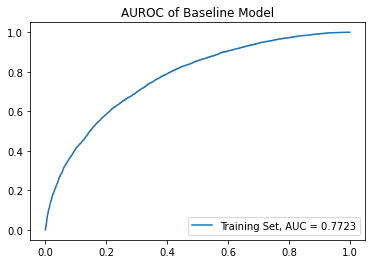

In [26]:
# Plot AUROC
y_pred_proba = logreg.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

plt.plot(fpr, tpr, label = "Training Set, AUC = " + str(round(auc, 4)))
plt.legend(loc = 4)
plt.title("AUROC of Baseline Model")
plt.show()

### Model Improvement
* Random Search for parameter tuning
* Variable selection
* Finding the best cut-off (Youden Index)

In [27]:
# Random search for parameters
distributions = dict(C = uniform(loc = 0, scale = 4), penalty = ['l2', 'l1'])
clf = RandomizedSearchCV(logreg, distributions, random_state = 1234)
search = clf.fit(X_train, y_train)
search.best_params_

In [28]:
# Build and fit a baseline model using statsmodel 
base_mdl = sm.GLM(y_train, X_train, family = sm.families.Binomial()).fit()
base_mdl_summary = base_mdl.summary()

# Save summary table as dataframe
summary_as_html = base_mdl_summary.tables[1].as_html()
summary_df = pd.read_html(summary_as_html, header = 0, index_col = 0)[0]

# Filter and print predictor variables with the p-value < 0.00004
summary_df[summary_df.iloc[:, 3] < 0.00004].index

Index(['x7', 'x8', 'x11', 'x19', 'x28', 'x36', 'x40', 'x47', 'x51', 'x61',
       'x82', 'x89', '1', '4', '5', '6', '7', '8', '9', '11', '13', '16', '21',
       '22', '24', '25', '28', '34', '46', '50', '59', '60', '64', '77', '78',
       '79', '80', '85', '91', '92', '93'],
      dtype='object')

In [29]:
# Build and fit a model with selected variables and parameters
X_train_new = X_train[['x7', 'x8', 'x11', 'x19', 'x28', 'x36', 'x40', 'x47', 'x51', 'x61', 'x82', 'x89', 
                       1, 4, 5, 6, 7, 8, 9, 11, 13, 16, 21, 22, 24, 25, 28, 34, 46, 50, 59, 60, 64, 77, 
                       78, 79, 80, 85, 91, 92, 93]]

logreg2 = LogisticRegression(solver = 'liblinear', 
                             max_iter = 100,
                             C = 1.1058570205723868,
                             penalty = 'l1',
                             random_state = 1234).fit(X_train_new, y_train)

# Compute accuracy and AUC on training data
accuracy = accuracy_score(y_train, logreg2.predict(X_train_new))
auc = roc_auc_score(y_train, logreg2.predict_proba(X_train_new)[:, 1])

# Print accuracy and AUC
print("Accuracy : %0.4f" % accuracy)
print("Area under the ROC curve : %0.4f" % auc)

Accuracy : 0.8593
Area under the ROC curve : 0.7627


In [30]:
# Find the best cut-off value (Youden Index)
i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                    'tpr' : pd.Series(tpr, index = i), 
                    '1-fpr' : pd.Series(1-fpr, index = i), 
                    'tf' : pd.Series(tpr - (1-fpr), index = i), 
                    'cut-off' : pd.Series(thresholds, index = i)})

roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,cut-off
5272,0.301459,0.698432,0.698541,-0.000109,0.147494


In [31]:
# Classify predicted probabilities by the 'best' cut-off
y_pred_new = []
for i in y_pred_proba:
    if i > 0.147494:
        y_pred_new.append(1)
    else:
        y_pred_new.append(0)
        
# Print accuracy
accuracy_new = accuracy_score(y_train, y_pred_new)
print("Accuracy : %0.4f" % accuracy_new)

Accuracy : 0.6985


Since all trials to improve a model performance turned out not to work out, I determined to use the model with basic parameters as the final model to generate the predicted probabilities for the test data.

### Predictions

In [32]:
# Predictions on test data
y_test_pred_lr = pd.DataFrame(logreg.predict_proba(X_test)[:, 1])

# Print first 10 predicted values and length of the predictions
print(y_test_pred_lr.head(10))
print()
print(len(y_test_pred_lr))

# Create a csv file 
y_test_pred_lr.to_csv(r'C:\Users\james\OneDrive\Desktop\Coding\Jupyter Notebook\State Farm\James Jeong_glmresults.csv', 
                      index = False, 
                      header = False)

          0
0  0.023376
1  0.074700
2  0.276968
3  0.095152
4  0.014941
5  0.032085
6  0.234335
7  0.047642
8  0.384959
9  0.694571

10000


## XGBoost
### Model Building

In [33]:
# Split data sets for model building
X_train_xgb, y_train_xgb = train_new.iloc[:, 1:], train_new.iloc[:, 0]
X_test_xgb = test_new

In [34]:
# Build a baseline model with cross-validation
# Create the DMatrix 
xgb_dmatrix = xgb.DMatrix(data = X_train_xgb, label = y_train_xgb)

# Set up an initial parameters
init_params = {'objective' : 'binary:logistic',
               'learning_rate' : 0.1,
               'max_depth' : 5,
               'subsample' : 0.8,
               'colsample_bytree' : 0.8,
               'eval_metric': 'auc'}

# Perform CV with initial parameters
cv_results = xgb.cv(dtrain = xgb_dmatrix,
                    params = init_params,
                    metrics = 'auc',
                    nfold = 5,
                    num_boost_round = 50,
                    early_stopping_rounds = 10,
                    as_pandas = True,
                    seed = 1234)

# Print the mean auc from CV
mean_auc = cv_results['test-auc-mean'].iloc[-1]
print('Mean AUC from cross-validation: %.4f' % mean_auc)

Mean AUC from cross-validation: 0.7893


### Parameter Tuning

In [35]:
# Random search
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
    'reg_lambda': [1, 10, 100],
    'n_estimators': [10, 50, 100, 200],
    'max_depth': range(3, 6),
    'subsample': [0.3, 0.5, 0.8],
    'colsample_bytree': [0.3, 0.5, 0.8],
}

# Instantiate the classifier: gbm
gbm = xgb.XGBClassifier(booster = 'gbtree',
                        objective = 'binary:logistic',
                        eval_metric = 'auc',
                        use_label_encoder = False,
                        seed = 1234)

# Perform random search
random_auc = RandomizedSearchCV(estimator = gbm, 
                                param_distributions = gbm_param_grid,
                                scoring = 'roc_auc',
                                cv = 5,
                                random_state = 1234)

random_auc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           scale_pos_weight=None, seed=1234,
                                           subsample=None, tree_method=None,
                           

In [36]:
# Print the best parameters and highest AUC
print("Best parameters found: ", random_auc.best_params_)
print("Highest AUC found: ", random_auc.best_score_)

Best parameters found:  {'subsample': 0.3, 'reg_lambda': 100, 'reg_alpha': 0.05, 'n_estimators': 200, 'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.5}
Highest AUC found:  0.7914986261551278


In [37]:
# Build a final model for predictions using Sklearn API
xgb_clf_final = xgb.XGBClassifier(booster = 'gbtree',
                                  objective = 'binary:logistic',
                                  eta = 0.1,
                                  gamma = 0,
                                  max_depth = 4,
                                  subsample = 0.8,
                                  colsample_bytree = 0.3,
                                  reg_lambda = 1,
                                  reg_alpha = 1,
                                  n_estimators = 100,
                                  eval_metric = 'auc',
                                  use_label_encoder = False,
                                  seed = 1234)

# Fit and trian XGBoost on training data
xgb_clf_final.fit(X_train, y_train)

# Check training accuracy with K-fold CV
kfold = KFold(n_splits = 5, shuffle = True)
kf_cv_score = cross_val_score(xgb_clf_final,
                              X_train,
                              y_train,
                              cv = kfold,
                              scoring = 'roc_auc')

print("Mean cross-validation AUC score: %.4f" % kf_cv_score.mean())

Mean cross-validation AUC score: 0.7973


In [38]:
# Print accuracy and AUC on training data
print("Accuracy: %.4f" % accuracy_score(y_train, xgb_clf_final.predict(X_train)))
print("Area under the ROC curve: %.4f" % roc_auc_score(y_train, xgb_clf_final.predict_proba(X_train)[:, 1]))

Accuracy: 0.8676
Area under the ROC curve: 0.8405


In [39]:
# Predictions on the test data
y_test_pred_xgb = pd.DataFrame(xgb_clf_final.predict_proba(X_test)[:, 1])

# Print first 10 predicted values and length of the predictions
print(y_test_pred_xgb.head(10))
print()
print(len(y_test_pred_xgb))

# Create a csv file 
y_test_pred_xgb.to_csv(r'C:\Users\james\OneDrive\Desktop\Coding\Jupyter Notebook\State Farm\James Jeong_nonglmresults.csv', 
                       index = False, 
                       header = False)

          0
0  0.017467
1  0.036045
2  0.219172
3  0.211056
4  0.009972
5  0.052041
6  0.317085
7  0.138779
8  0.089825
9  0.492974

10000


### Feature Importance

In [40]:
# Feature importance from the final model
# Create a parameter discitonary
fnl_params = {'booster' : 'gbtree',
              'objective' : 'binary:logistic',
              'learning_rate': 0.1,
              'gamma': 0,
              'alpha': 1,
              'lambda': 1,
              'max_depth' : 4,
              'subsample' : 0.8,
              'colsample_bytree': 0.3,
              'eval_metric': 'auc'
             }

# Train the final model
xgb_clf_fnl = xgb.train(params = fnl_params,
                        dtrain = xgb_dmatrix,
                        num_boost_round = 100)

<AxesSubplot:title={'center':'Top 20 Feature Importance'}>

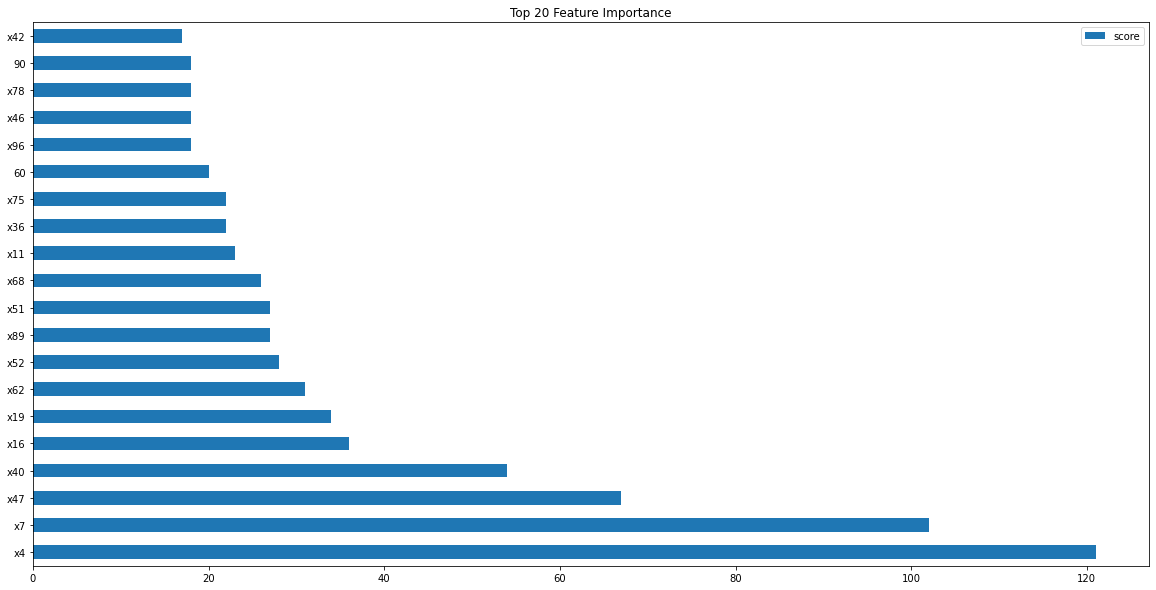

In [41]:
# Feature importance
ft_imp_fnl = xgb_clf_fnl.get_score(importance_type = 'weight')
keys = list(ft_imp_fnl.keys())
values = list(ft_imp_fnl.values())

ft_imp_fnl_df = pd.DataFrame(data = values, 
                             index = keys, 
                             columns = ['score']).sort_values(by = 'score')

# Print top 20 features
ft_imp_fnl_df.head(20)

# Plot the importance of top 20 features
ft_imp_fnl_df.nlargest(20, columns = 'score').plot(kind = 'barh', 
                                                   figsize = (20, 10), 
                                                   title = 'Top 20 Feature Importance')

# Code Appendix

In [ ]:
# Variable selection: Backward - takes too much time
bwd_sel = sfs(logreg, 
              k_features = 30, 
              forward = False, 
              floating = False, 
              scoring = 'roc_auc', 
              cv = None)

bwd_sel_fit = bwd_sel.fit(X_train, y_train)
print(bwd_sel_fit.k_feature_names_)

In [ ]:
# Learning rate
# Create the list of eta values and empty list to store final auc
eta_vals = [0.001, 0.01, 0.1]
auc_ls = []

# Systemically vary the eta
for curr_val in eta_vals:
    params['eta'] = curr_val
    
    # Perform CV
    cv_results = xgb.cv(dtrain = xgb_dmatrix,
                        params = init_params,
                        nfold = 5,
                        num_boost_round = 50,
                        early_stopping_rounds = 10,
                        metrics = 'auc',
                        as_pandas = True,
                        seed = 1234)
    auc_ls.append(cv_results['test-auc-mean'].tail(1).values[0])

# Print results
print(pd.DataFrame(list(zip(eta_vals, auc_ls)), columns = ['eta', 'auc']))

In [ ]:
# Regularization parameters: alpha, lambda
# Define alphas & lambdas
l1_params = [0.01, 0.05, 0.1, 0.5, 1]
l2_params = [1, 10, 100]

# Initialize an empty list
auc_l1 = []
auc_l2 = []

# for loop to iterate over each entry in each list
for reg1 in l1_params:
    params['alpha'] = reg1
    cv_results = xgb.cv(dtrain = xgb_dmatrix,
                        params = init_params,
                        nfold = 5,
                        num_boost_round = 50,
                        early_stopping_rounds = 10,
                        metrics = 'auc',
                        as_pandas = True,
                        seed = 1234)
    auc_l1.append(cv_results['test-auc-mean'].tail(1).values[0])
    
for reg2 in l2_params:
    params['lambda'] = reg2
    cv_results = xgb.cv(dtrain = xgb_dmatrix,
                        params = init_params,
                        nfold = 5,
                        num_boost_round = 50,
                        early_stopping_rounds = 10,
                        metrics = 'auc',
                        as_pandas = True,
                        seed = 1234)
    auc_l2.append(cv_results['test-auc-mean'].tail(1).values[0])

# Print auc per term
print(pd.DataFrame(list(zip(l1_params, auc_l1)), columns = ['alpha', 'auc']))
print(pd.DataFrame(list(zip(l2_params, auc_l2)), columns = ['lambda', 'auc']))